# Yield Model Simulator for D2W hybrid bonding
#### Author: Zhichao Chen
#### Date: Aug 25, 2025
#### Description: YAP+ (pad-layout-aware yield analysis)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from utils.util import *
import time
import matplotlib.pyplot as plt
from assembly_yield_simulator import Assembly_Yield_Simulator
from pad_bitmap_generation import pad_bitmap_generate_random

PAD_ARR_ROW: 10000
PAD_ARR_COL: 10000
Number of pad blocks: 10000
Pad block size: 100
Number of critical pad blocks: 9999
Number of redundant pad blocks: 1
Number of dummy pad blocks: 0
Processing redundant block 1/1...  cluster size: 25
Pad bitmap collections info saved.
Processing 1/1, particle dednsity: 1e-09, translation: 0.01, dish_std: 1.0
Processing die 0/100...
The assembly yield is 85.00%.
The assembly yield list is:  [0.85]
Total time taken: 73.60 seconds


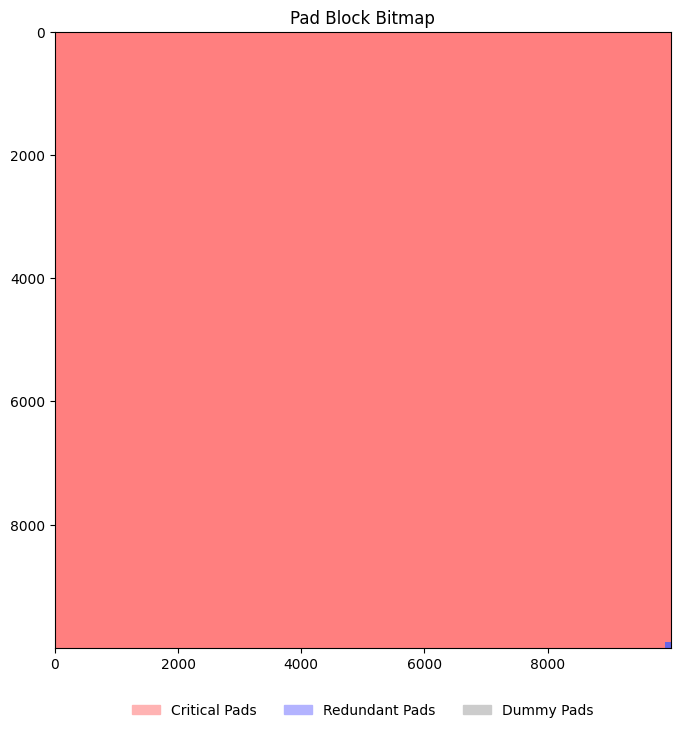

In [6]:
# Load configuration
cfg = load_modeling_config(path='configs/config.yaml', 
                     mode='d2w_simulation',
                     debug=False)
num_points = 1     # Number of points for parameter sweep
# Explore the impact of all factors on the assembly yield
die_size_list = np.linspace(1e+4, 1e+4, num_points)
pitch_list = np.linspace(1, 1, num_points)
# particle_density_list = np.linspace(1e-8, 1e-8, num_points)  # More uniform distribution
particle_density_list = np.linspace(1e-9, 1e-9, num_points) 
t_0_list = np.linspace(0.1, 0.1, num_points)
dish_std_list = np.linspace(1, 1, num_points)
translation_list = np.linspace(1e-2, 1e-2, num_points)
rotation_mean_list = np.logspace(-7, -7, num_points)
Roughness_sigma_list = np.linspace(1.0e-9, 1.0e-9, num_points)
PAD_BOT_R_ratio_list = np.linspace(0.5, 0.5, num_points)
PAD_TOP_R_ratio_list = np.linspace(2/3, 2/3, num_points)
bow_difference_mean_list = np.linspace(10, 10, num_points)

assembly_yield_list = []

# Generate pad bitmap collection
pad_bitmap_collection = pad_bitmap_generate_random(cfg=cfg)  

start_time = time.time()
single_config_yield_list_array = np.zeros([len(particle_density_list), cfg.simulation_times * cfg.NUM_DIES])
cfg.approximate_set = 100
cfg.NUM_DIES = 100  # Number of dies to simulate

for i in range(num_points):
    print("Processing {}/{}, particle dednsity: {}, translation: {}, dish_std: {}".format(i + 1, len(particle_density_list), particle_density_list[i], translation_list[i], dish_std_list[i]))
    # Update parameters
    cfg.DIE_W = float(die_size_list[i])  # die width (um)
    cfg.DIE_L = float(die_size_list[i])  # die length (um)
    cfg.PITCH = float(pitch_list[i])  # pitch (um)
    cfg.PAD_TOP_R_ratio = float(PAD_TOP_R_ratio_list[i])  # top Cu pad radius ratio
    cfg.PAD_BOT_R_ratio = float(PAD_BOT_R_ratio_list[i])  # bottom Cu pad radius ratio
    cfg.SYSTEM_TRANSLATION_X_MEAN = float(translation_list[i])  # systematic translation mean (um) - x direction
    cfg.SYSTEM_TRANSLATION_Y_MEAN = float(translation_list[i])  # systematic translation mean (um) - y direction
    cfg.SYSTEM_ROTATION_MEAN = float(rotation_mean_list[i])  # systematic rotation mean (rad)
    cfg.D0 = float(particle_density_list[i])  # particle density (um^{-2})
    cfg.t_0 = float(t_0_list[i])  # smallest particle thickness (um)
    cfg.BOW_DIFFERENCE_MEAN = float(bow_difference_mean_list[i])  # bow difference mean (um)
    cfg.TOP_DISH_STD = float(dish_std_list[i])  # Top Cu pad dish standard deviation (nm)
    cfg.BOT_DISH_STD = float(dish_std_list[i])  # Bottom Cu pad dish standard deviation (nm)
    cfg.Roughness_sigma = float(Roughness_sigma_list[i])  # Surface roughness standard deviation (m)
    # Update above parameters in the configuration
    update_config_items(cfg=cfg, mode='d2w_simulation')

    assembly_yield, single_config_yield_list = Assembly_Yield_Simulator(
        cfg=cfg,
        pad_bitmap_collection=pad_bitmap_collection,                                               
    )
                                                                        
    assembly_yield_list.append(assembly_yield)
    single_config_yield_list_array[i] = np.array(single_config_yield_list).flatten()
    
    if i % 10 == 0 or i == len(particle_density_list) - 1:
        print("The assembly yield list is: ", assembly_yield_list)
        # # # Save the data
# np.save("correlation/sim_config_info_ovl_300pts_20000dies.npy", cfg)
# np.save("correlation/sim_yield_list_ovl_300pts_20000dies.npy", assembly_yield_list)
# np.save("correlation/single_config_yield_list_array_ovl_300pts_20000dies.npy", single_config_yield_list_array)
print("Total time taken: {:.2f} seconds".format(time.time() - start_time))

In [ ]:
# np.save('correlation/particle_density/sim_df_yield_list_pd_-10_-7d56_size_1e4_300params_200dim.npy', assembly_yield_list)

In [ ]:
for i in range(len(assembly_yield_list)):
    print(assembly_yield_list[i])